In [1]:
# === Core scientific libraries ===
import numpy as np
import pandas as pd

# === Statsmodels (econometrics / statistical modeling) ===
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS

# === Causal inference (DoubleML) ===
import doubleml as dml
from doubleml import DoubleMLData, DoubleMLPLR, DoubleMLIRM

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Scipy (scientific functions) ===
from scipy import stats
from scipy.stats import norm, expon
from scipy.special import expit

# === Utilities ===
import warnings

In [2]:
from pathlib import Path
this_dir = Path (".")
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"

In [3]:
file_path = obtained_data_dir / "original_data_policy_scaled.xlsx"
scaled_df = pd.read_excel(file_path)

In [4]:
from help_func import find_optimal_learners
from help_func import find_optimal_lasso
from help_func import find_optimal_xgboost

In [5]:
np.random.seed(42)

### Fixed effects

In [6]:

# get dummies
country_dummies = pd.get_dummies(scaled_df['Country'], prefix='country', drop_first=True)

scaled_df_with_fe = pd.concat([scaled_df, country_dummies], axis=1)


print(scaled_df_with_fe)
print(f"New demension: {scaled_df_with_fe.shape}")

         Country  Year  waste_per_cap  Policy  Group   env_tax  unemp_rate  \
0       Bulgaria  2015            431       0      0  0.439746    0.352174   
1        Czechia  2015            316       0      0  0.249471    0.134783   
2        Germany  2015            632       0      1  0.221987    0.104348   
3        Estonia  2015            359       0      0  0.393235    0.191304   
4        Ireland  2015            571       0      1  0.215645    0.343478   
..           ...   ...            ...     ...    ...       ...         ...   
185     Slovenia  2022            487       1      1  0.422833    0.086957   
186     Slovakia  2022            478       0      0  0.338266    0.178261   
187       Sweden  2022            395       1      1  0.219873    0.239130   
188  Switzerland  2022            677       0      0  0.084567    0.091304   
189       Serbia  2022            473       1      1  0.534884    0.330435   

     rexp_per_cap   urb_ind  country_Croatia  ...  country_Neth

In [7]:
ml_df = scaled_df_with_fe
bool_cols = ml_df.select_dtypes(include='bool').columns

# (True -> 1, False -> 0)
ml_df[bool_cols] = ml_df[bool_cols].astype(int)

In [8]:
warnings.filterwarnings('ignore', category=UserWarning, message='Propensity predictions from learner')

In [9]:
ml_df = ml_df.drop('Country', axis=1)

country_dummy_cols = [col for col in ml_df.columns if col.startswith('country_')]

x_cols = ['env_tax', 'rexp_per_cap', 'urb_ind', 'unemp_rate'] + country_dummy_cols
obj_dml_data_f = dml.DoubleMLData(ml_df, 'waste_per_cap', 'Group', x_cols=x_cols)

X_g_f = obj_dml_data_f.x
y_g_f = obj_dml_data_f.y
X_m_f = obj_dml_data_f.x
y_m_f = obj_dml_data_f.d

optimal_ml_g_f = find_optimal_learners(X_g_f, y_g_f, is_classifier=False)
optimal_ml_m_f = find_optimal_learners(X_m_f, y_m_f, is_classifier=True)

dml_obj_f = dml.DoubleMLIRM(obj_dml_data_f, optimal_ml_g_f, optimal_ml_m_f, n_folds=5, n_rep=5)
print(dml_obj_f.fit())

Fitting 5 folds for each of 45 candidates, totalling 225 fits

--- Optimal Parameters for Regressor ---
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
Fitting 5 folds for each of 45 candidates, totalling 225 fits

--- Optimal Parameters for Classifier ---
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 30}
================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: waste_per_cap
Treatment variable(s): ['Group']
Covariates: ['env_tax', 'rexp_per_cap', 'urb_ind', 'unemp_rate', 'country_Croatia', 'country_Cyprus', 'country_Czechia', 'country_Estonia', 'country_France', 'country_Germany', 'country_Greece', 'country_Hungary', 'country_Ireland', 'country_Italy', 'country_Latvia', 'country_Lithuania', 'country_Malta', 'country_Netherlands', 'country_Poland', 'country_Portugal', 'country_Romania', 'country_Serbia', 'country_Slovakia', 'country_Slovenia', 'country_Sp

In [10]:
optimal_lasso_g_f = find_optimal_lasso(X_g_f, y_g_f, is_classifier=False)
optimal_lasso_m_f = find_optimal_lasso(X_m_f, y_m_f, is_classifier=True)

dml_lasso_f = dml.DoubleMLIRM(obj_dml_data_f, optimal_lasso_g_f, optimal_lasso_m_f, n_folds=5, n_rep=5)
print(dml_lasso_f.fit())

Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Optimal Parameters for Lasso Regressor ---
Best parameters: {'alpha': 0.1707352647470692}
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Optimal Parameters for Lasso Classifier ---
Best parameters: {'C': 1.0, 'penalty': 'l1'}
================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: waste_per_cap
Treatment variable(s): ['Group']
Covariates: ['env_tax', 'rexp_per_cap', 'urb_ind', 'unemp_rate', 'country_Croatia', 'country_Cyprus', 'country_Czechia', 'country_Estonia', 'country_France', 'country_Germany', 'country_Greece', 'country_Hungary', 'country_Ireland', 'country_Italy', 'country_Latvia', 'country_Lithuania', 'country_Malta', 'country_Netherlands', 'country_Poland', 'country_Portugal', 'country_Romania', 'country_Serbia', 'country_Slovakia', 'country_Slovenia', 'country_Spain', 'country_Sweden', 'country_Switzerland']
Inst

In [11]:
optimal_xgboost_g_f = find_optimal_xgboost(X_g_f, y_g_f, is_classifier=False)
optimal_xgboost_m_f = find_optimal_xgboost(X_m_f, y_m_f, is_classifier=True)

dml_irm_boost_f = dml.DoubleMLIRM(obj_dml_data_f,
                                 ml_g = optimal_xgboost_g_f,
                                 ml_m = optimal_xgboost_m_f,
                                 n_folds = 5,
                                 n_rep = 5)
dml_irm_boost_f.fit(store_predictions=True)
boost_summary = dml_irm_boost_f.summary
print(boost_summary)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\Users\Anna\anaconda3\envs\res\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



--- Optimal Parameters for XGBoost Regressor ---
Best parameters: {'learning_rate': 0.1788888888888889, 'max_depth': 1, 'n_estimators': 200}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

--- Optimal Parameters for XGBoost Classifier ---
Best parameters: {'learning_rate': 0.1577777777777778, 'max_depth': 3, 'n_estimators': 50}
            coef    std err         t     P>|t|      2.5 %     97.5 %
Group  51.963328  10.664698  4.872461  0.000001  26.011439  71.390393


### CRE Method (Mundlak)

In [12]:
cre_df = scaled_df

In [13]:
selected_countries = ["Czechia", "Ireland", "Cyprus", "Hungary", "Serbia", 
                       "Sweden", "France", "Spain", "Netherlands", "Germany", "Italy",
                       "Poland", "Lithuania", "Portugal", "Latvia", "Malta", 
                       "Slovenia", "Estonia", "Croatia", "Greece", "Bulgaria", "Slovakia", "Switzerland", "Romania"]

In [14]:
columns_to_normalize = ['waste_per_cap', 'env_tax', 'unemp_rate', 'rexp_per_cap', 'urb_ind']

# Subtracting the mean value for each country across all years
for col in columns_to_normalize:
    # Group by 'Country' and calculate the mean for each group
    country_means = cre_df.groupby('Country')[col].mean()

    cre_df[f'{col}_mean'] = cre_df['Country'].map(country_means)

    # Subtract the mean value of each country from the corresponding values
    cre_df[f'{col}_centered'] = cre_df.apply(
        lambda row: row[col] - country_means[row['Country']], axis=1
    )

print(cre_df)

         Country  Year  waste_per_cap  Policy  Group   env_tax  unemp_rate  \
0       Bulgaria  2015            431       0      0  0.439746    0.352174   
1        Czechia  2015            316       0      0  0.249471    0.134783   
2        Germany  2015            632       0      1  0.221987    0.104348   
3        Estonia  2015            359       0      0  0.393235    0.191304   
4        Ireland  2015            571       0      1  0.215645    0.343478   
..           ...   ...            ...     ...    ...       ...         ...   
185     Slovenia  2022            487       1      1  0.422833    0.086957   
186     Slovakia  2022            478       0      0  0.338266    0.178261   
187       Sweden  2022            395       1      1  0.219873    0.239130   
188  Switzerland  2022            677       0      0  0.084567    0.091304   
189       Serbia  2022            473       1      1  0.534884    0.330435   

     rexp_per_cap   urb_ind  waste_per_cap_mean  waste_per_cap_

In [15]:
obj_dml_data = dml.DoubleMLData(cre_df, 'waste_per_cap', 'Group', x_cols=[ 'env_tax_mean', 'rexp_per_cap_mean', 'urb_ind_mean', "unemp_rate_mean", 'env_tax', 'rexp_per_cap', 'urb_ind', "unemp_rate"])

# Find optimal learners
X_g = obj_dml_data.x
y_g = obj_dml_data.y
X_m = obj_dml_data.x
y_m = obj_dml_data.d

optimal_ml_g = find_optimal_learners(X_g, y_g, is_classifier=False)
optimal_ml_m = find_optimal_learners(X_m, y_m, is_classifier=True)

dml_obj = dml.DoubleMLIRM(obj_dml_data, optimal_ml_g, optimal_ml_m, n_folds=5, n_rep=5)
print(dml_obj.fit())

Fitting 5 folds for each of 45 candidates, totalling 225 fits



--- Optimal Parameters for Regressor ---
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
Fitting 5 folds for each of 45 candidates, totalling 225 fits

--- Optimal Parameters for Classifier ---
Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 30}
================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: waste_per_cap
Treatment variable(s): ['Group']
Covariates: ['env_tax_mean', 'rexp_per_cap_mean', 'urb_ind_mean', 'unemp_rate_mean', 'env_tax', 'rexp_per_cap', 'urb_ind', 'unemp_rate']
Instrument variable(s): None
No. Observations: 190

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)
Learner ml_m: RandomForestClassifier(max_depth=3, n_estimators=30, random_state=42)
Out-of-sample Performance:


In [16]:
dml_ate_prf = dml_obj.summary.loc['Group', 'coef']
dml_std_prf = dml_obj.summary.loc['Group', 'std err']

In [17]:
optimal_lasso_g = find_optimal_lasso(X_g, y_g, is_classifier=False)
optimal_lasso_m = find_optimal_lasso(X_m, y_m, is_classifier=True)

dml_irm_lasso = dml.DoubleMLIRM(obj_dml_data, optimal_lasso_g, optimal_lasso_m, n_folds=5, n_rep=5)
print(dml_irm_lasso.fit())

Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Optimal Parameters for Lasso Regressor ---
Best parameters: {'alpha': 1.0}
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Optimal Parameters for Lasso Classifier ---
Best parameters: {'C': 1.0, 'penalty': 'l1'}
================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: waste_per_cap
Treatment variable(s): ['Group']
Covariates: ['env_tax_mean', 'rexp_per_cap_mean', 'urb_ind_mean', 'unemp_rate_mean', 'env_tax', 'rexp_per_cap', 'urb_ind', 'unemp_rate']
Instrument variable(s): None
No. Observations: 190

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: Lasso(random_state=42)
Learner ml_m: LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[61.65924014]
 [61

In [18]:
dml_ate_pl = dml_irm_lasso.summary.loc['Group', 'coef']
dml_std_pl = dml_irm_lasso.summary.loc['Group', 'std err']

In [19]:
optimal_xgboost_g = find_optimal_xgboost(X_g, y_g, is_classifier=False)
optimal_xgboost_m = find_optimal_xgboost(X_m, y_m, is_classifier=True)

dml_irm_boost = dml.DoubleMLIRM(obj_dml_data,
                                 ml_g = optimal_xgboost_g,
                                 ml_m = optimal_xgboost_m,
                                 n_folds = 5,
                                 n_rep = 5)
dml_irm_boost.fit(store_predictions=True)
boost_summary = dml_irm_boost.summary
print(boost_summary)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits

--- Optimal Parameters for XGBoost Regressor ---
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

--- Optimal Parameters for XGBoost Classifier ---
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
            coef   std err         t         P>|t|      2.5 %     97.5 %
Group  73.993922  8.290019  8.925664  4.430332e-19  57.572316  90.242061


In [20]:
dml_ate_pxgb = dml_irm_boost.summary.loc['Group', 'coef']
dml_std_pxgb = dml_irm_boost.summary.loc['Group', 'std err']

In [21]:
results_file_path = obtained_data_dir / "Bayesian_results.txt"

if not results_file_path.exists():
    print(f"Error: The file {results_file_path} was not found.")
else:
    def read_results(filepath):
        results = {}
        with open(filepath, 'r') as f:
            for line in f:
                if not line.strip():
                    continue
                # Split the line at the '=' sign
                try:
                    key, value = line.strip().split('=')
                    results[key] = float(value)
                except ValueError:
                    print(f"Skipping malformed line: {line.strip()}")
        return results

    results_dict = read_results(results_file_path)

    # Assign the values to the variables
    bayes_mean = results_dict['bayes_mean']
    bayes_std = results_dict['bayes_std']
    
    pa_bayes_mean = results_dict['pa_bayes_mean']
    pa_bayes_std = results_dict['pa_bayes_std']
    
    dr_bayes_mean = results_dict['dr_bayes_mean']
    dr_bayes_std = results_dict['dr_bayes_std']

    print("Successfully loaded results from MATLAB.")
    print(f"Bayes Mean: {bayes_mean}")
    print(f"PA Bayes Mean: {pa_bayes_mean}")
    print(f"DR Bayes Mean: {dr_bayes_mean}")

Successfully loaded results from MATLAB.
Bayes Mean: 56.933
PA Bayes Mean: 59.333
DR Bayes Mean: 57.126


In [22]:
import pickle
import os

file_path = os.path.join(obtained_data_dir, 'dml_results.pkl')

with open(file_path, 'rb') as f:
    dml_results = pickle.load(f)

ate_or_tr = dml_results['or']['ate_tr']

print("Results obtained.")

Results obtained.


In [23]:
x_values = np.linspace(-20, 150, 1000)

# PDF for each Bayesian model
pdf_bayes = stats.norm.pdf(x_values, bayes_mean, bayes_std)
pdf_pa_bayes = stats.norm.pdf(x_values, pa_bayes_mean, pa_bayes_std)
pdf_dr_bayes = stats.norm.pdf(x_values, dr_bayes_mean, dr_bayes_std)

# PDF for each DML model
pdf_dml_rf = stats.norm.pdf(x_values, dml_ate_prf, dml_std_prf)
pdf_dml_lasso = stats.norm.pdf(x_values, dml_ate_pl, dml_std_pl)
pdf_dml_xgb = stats.norm.pdf(x_values, dml_ate_pxgb, dml_std_pxgb)


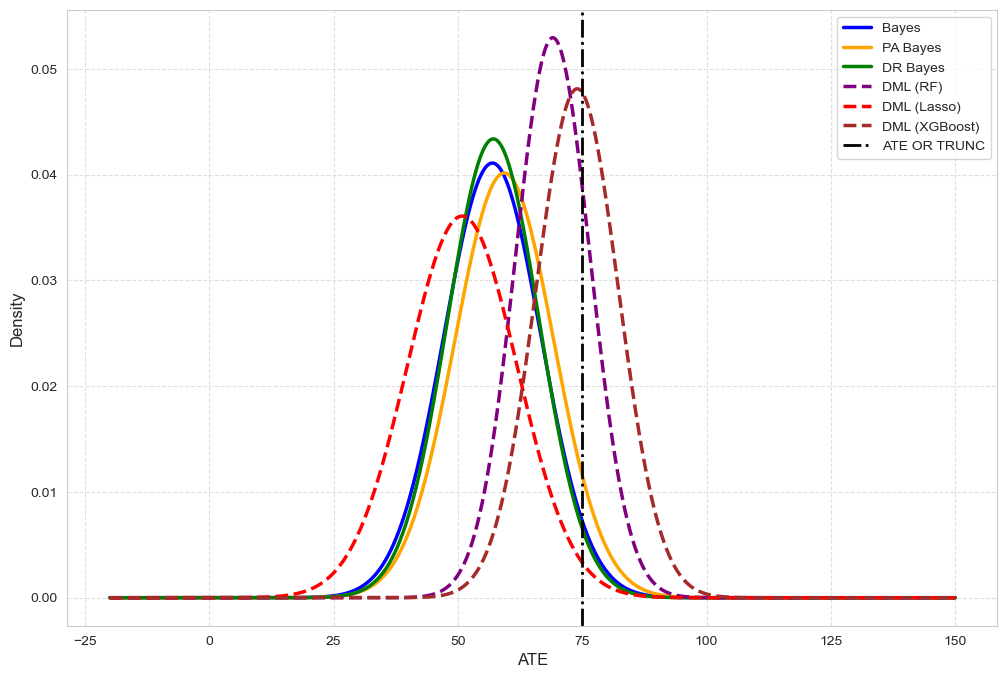

In [24]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Bayesian distributions as density curves
plt.plot(x_values, pdf_bayes, label='Bayes', color='blue', linewidth=2.5)
plt.plot(x_values, pdf_pa_bayes, label='PA Bayes', color='orange', linewidth=2.5)
plt.plot(x_values, pdf_dr_bayes, label='DR Bayes', color='green', linewidth=2.5)

# DML distributions as density curves
plt.plot(x_values, pdf_dml_rf, label='DML (RF)', color='purple', linestyle='--', linewidth=2.5)
plt.plot(x_values, pdf_dml_lasso, label='DML (Lasso)', color='red', linestyle='--', linewidth=2.5)
plt.plot(x_values, pdf_dml_xgb, label='DML (XGBoost)', color='brown', linestyle='--', linewidth=2.5)

# OLS ATE estimate as a vertical dashed line
plt.axvline(ate_or_tr, color='black', linestyle='-.', linewidth=2, label='ATE OR TRUNC')

plt.xlabel('ATE', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()